# Installation
CNGI documentation is located here:
[https://cngi-prototype.readthedocs.io/en/latest/index.html](https://cngi-prototype.readthedocs.io/en/latest/index.html)

Google Colab requires specific older versions of some packages such as Pandas and Dask, so we will install CNGI without its normal dependencies and then manually install each dependency afterwards.

Normally, you would want to leave out the --no-dependencies option

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide

In [1]:
import os
import numpy as np
import logging
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR) # dask is noisy

print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks==6.0.0.27")
os.system("pip install cngi-prototype==0.0.20 --no-dependencies")
os.system("pip install --upgrade dask")
os.system("pip install --upgrade xarray")
os.system("pip install --upgrade zarr")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


# Initialize the Processing Environment
InitializeFramework instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well.  The code is shown here commented out for reference only and the default dask configuration is returned for inspection.

In [2]:
# normally you would want to run something like this on a local machine
#from cngi.direct import InitializeFramework
#client = InitializeFramework(workers=2, memory='6GB')
#print(client)

# but the google colab environment is weird 
import dask
print('default settings core count: ', dask.multiprocessing.CPU_COUNT)

default settings core count:  2


# Create a CASA Image
First we need to create a CASA image by calling CASA6 tclean on the CASAguide MS

Pro tip: you can see the files being created by expanding the left navigation bar in colab (little arrow on top left) and going to "Files"

In [3]:
from casatasks import tclean
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='sis14_twhya_calibrated_flagged', field='5', spw='', 
       specmode='cube', deconvolver='hogbom', nterms=1, imsize=[250,250], gridder='standard', cell=['0.1arcsec'],
       nchan=10, weighting='natural', threshold='0mJy', niter=5000, interactive=False, savemodel='modelcolumn')
print('complete')

complete


# Convert the Image products to xarray/zarr format
tclean produces an image along with a number of supporting products (residual, pb, psf, etc) in their own separate directories.  

CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) data model and the zarr storage format which is capable of storing all image products (of the same shape) together.

In [4]:
from cngi.conversion import image_to_zarr

image_to_zarr('sis14_twhya_calibrated_flagged.image')

numpy version: 1.17.4
converting Image...
compatible components:  ['image', 'mask', 'model', 'pb', 'psf', 'residual']
separate components:  ['sumwt']
processing channel 1 of 10
processing channel 2 of 10
processing channel 3 of 10
processing channel 4 of 10
processing channel 5 of 10
processing channel 6 of 10
processing channel 7 of 10
processing channel 8 of 10
processing channel 9 of 10
processing channel 10 of 10
processed image size [250 250   1  10] in 1.2697141 seconds
processing sumwt channel 1 of 10
processing sumwt channel 2 of 10
processing sumwt channel 3 of 10
processing sumwt channel 4 of 10
processing sumwt channel 5 of 10
processing sumwt channel 6 of 10
processing sumwt channel 7 of 10
processing sumwt channel 8 of 10
processing sumwt channel 9 of 10
processing sumwt channel 10 of 10
complete


# Open a zarr format Image

Open the zarr format image and print its contents.  Note that the zarr file has all the image products in it (rather than separate directories) except for sumwt, which remains its own file.  This is because sumwt has a different shape.


In [0]:
from cngi.dio import read_image

# returns an xarray dataset representation of the specified zarr directory
image_xds = read_image('sis14_twhya_calibrated_flagged.zarr')
sumwt_xds = read_image('sis14_twhya_calibrated_flagged.sumwt.zarr')

Within the xarray dataset image, we can see a very clear definition of the image properties.  The **Dimensions** section holds the size of the image, while the **Coordinates** section defines the values of each dimension.  The actual image (and supporting products) are stored in the **Data variables** section.  Lastly, the **Attributes** section holds the remaining metadata.

Note that the image, mask, model, pb, psf, and residual all share the same dimensions of 250x250x1x10

In [6]:
print(image_xds)

<xarray.Dataset>
Dimensions:          (d0: 250, d1: 250, frequency: 10, stokes: 1)
Coordinates:
    declination      (d0, d1) float64 dask.array<chunksize=(125, 250), meta=np.ndarray>
  * frequency        (frequency) float64 3.725e+11 3.725e+11 ... 3.725e+11
    right_ascension  (d0, d1) float64 dask.array<chunksize=(125, 250), meta=np.ndarray>
  * stokes           (stokes) float64 1.0
Dimensions without coordinates: d0, d1
Data variables:
    image            (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    mask             (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    model            (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    pb               (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    psf              (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.

The same structure is followed for sumwt, but with different dimensions (1x1x1x10)

In [7]:
print(sumwt_xds)

<xarray.Dataset>
Dimensions:          (d0: 1, d1: 1, frequency: 10, stokes: 1)
Coordinates:
    declination      (d0, d1) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * frequency        (frequency) float64 3.725e+11 3.725e+11 ... 3.725e+11
    right_ascension  (d0, d1) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * stokes           (stokes) float64 1.0
Dimensions without coordinates: d0, d1
Data variables:
    sumwt            (d0, d1, stokes, frequency) float64 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
Attributes:
    axisunits:            ['rad', 'rad', '', 'Hz']
    date_observation:     2012/11/19/07
    defaultmask:          
    direction_reference:  j2000
    hasmask:              False
    image_name:           sis14_twhya_calibrated_flagged.sumwt
    image_quantity:       intensity
    image_type:           pagedimage
    imagetype:            Intensity
    masks:                []
    object_name:          tw hya
    observer:             cqi
 

# Preview Image
We can quickly spot check image contents.  This is also handy later on during image manipulation and analysis

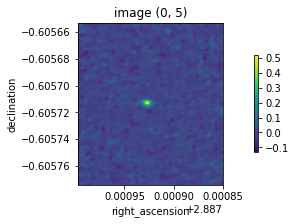

In [8]:
from cngi.image import preview
preview(image_xds, 'image', channels=5)

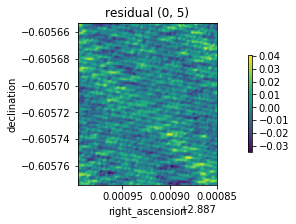

In [9]:
preview(image_xds, 'residual', channels=5)

# Image Manipulation
Many image operations can be easily done directly on the image xarray dataset

Example 1: imsubimage - copy all or part of an image to a new image

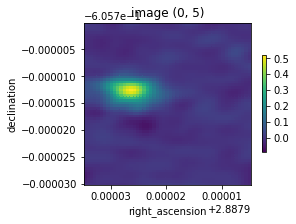

In [10]:
# selection by coordinate values
image_xds2 = image_xds.where( (image_xds.right_ascension > 2.887905) & (image_xds.right_ascension < 2.887935) &
                              (image_xds.declination > -0.60573) & (image_xds.declination < -0.60570), drop=True ) 
preview(image_xds2, channels=5)

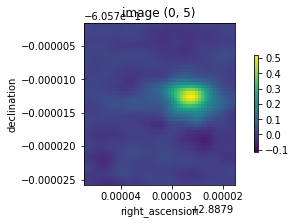

In [11]:
# selection by pixel indices (50x50 pixel square)
# note that this same method works for any other dimension (stokes, channels, etc)
image_xds2 = image_xds.isel(d0=np.arange(50)+85, d1=np.arange(50)+100) 
preview(image_xds2, channels=5)

# Regions and Masks
Both regions and masks are stored as boolean arrays in the same xarray dataset alongside the rest of the image components.  They always share the same dimensions as the image.

They are both now treated as the same thing, so a value of 0 means "discard this pixel" and a value of 1 means "keep this pixel" regardless of whether it is a mask or a region.  In fact, any xarray data variable of boolean type can be used as a region/mask, there is nothing special about the names.

Regions/masks can be set across any dimension, so they can be per-channel and per-stokes as well as the spatial dimensions.

First lets create a couple examples:

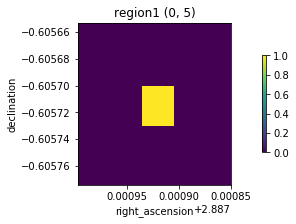

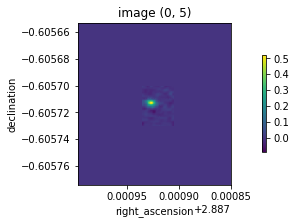

In [12]:
from cngi.image import region

# region 1 is an ra/dec box across all channels
image_xds2 = region(image_xds, 'region1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

# lets examine what it looks like
preview(image_xds2,'region1', channels=5)

# and combined with our image
preview(image_xds2, 'image', 'region1', channels=5)

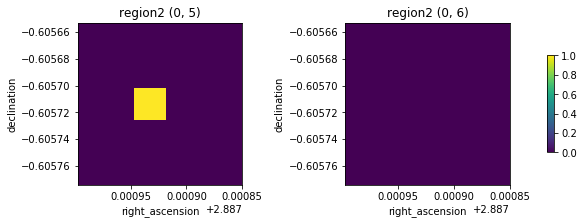

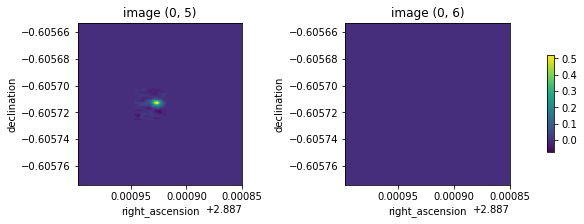

In [13]:
# region 2 is a pixel box across channels 3, 4 and 5
image_xds3 = region(image_xds2, 'region2', pixels=[[85,100],[135,150]], channels=[3,4,5])

# observe the change in behavior across channels
preview(image_xds3,'region2', channels=[5,6])
preview(image_xds3, 'image', 'region2', channels=[5,6])

Regions are just data variables in the xarray dataset. So we can manipulate them the same way we can any other variable.

In [14]:
image_xds3.data_vars

Data variables:
    image     (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    mask      (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    model     (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    pb        (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    psf       (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    residual  (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    region1   (d0, d1, stokes, frequency) bool dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    region2   (d0, d1, stokes, frequency) bool dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>

Let's combine the first two regions in to a new one (doesn't need to be contiguous, although it is here). It is just a logical OR of two boolean arrays (obviously you could do an AND, XOR, or whatever else).

Just keep in mind that these are 4-D arrays, not 2-D.

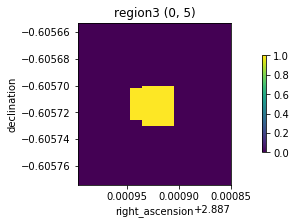

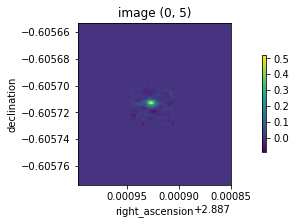

In [15]:
region3 = image_xds3.region1 | image_xds3.region2
image_xds4 = image_xds3.assign(dict([('region3', region3)]))
 
preview(image_xds4,'region3', channels=5)
preview(image_xds4, 'image', 'region3', channels=5)

Masks are just like regions but with inverse logic used to set them.  Here is the same code again using calls to mask instead of region.

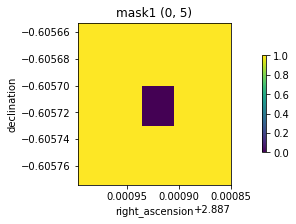

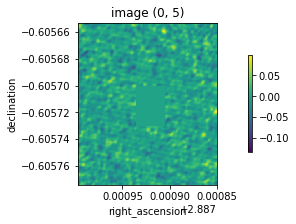

In [16]:
from cngi.image import mask

image_xds2 = mask(image_xds, 'mask1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

preview(image_xds2,'mask1', channels=5)
preview(image_xds2, 'image', 'mask1', channels=5)